In [50]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io
from PIL import Image
import cv2
import imutils
from scipy.spatial import distance as dist

segments_path = "/home/keeganfl/Desktop/Math_612_project/05-10-2015/cellpose_height/"

# Step 1
Loading up the data and then isolate the individual outlines and save the original image

In [58]:
dat = np.load(segments_path + '10061218_height_seg.npy', allow_pickle=True).item()

# Create a list that contains each outline
outl = utils.outlines_list(dat['masks'])

# save a copy of the basic image to be used and latered later. 
img = dat["img"]

# Step 2
Look at the individual outlines. (I mostly use this to get the context of where each outline is in the full image)

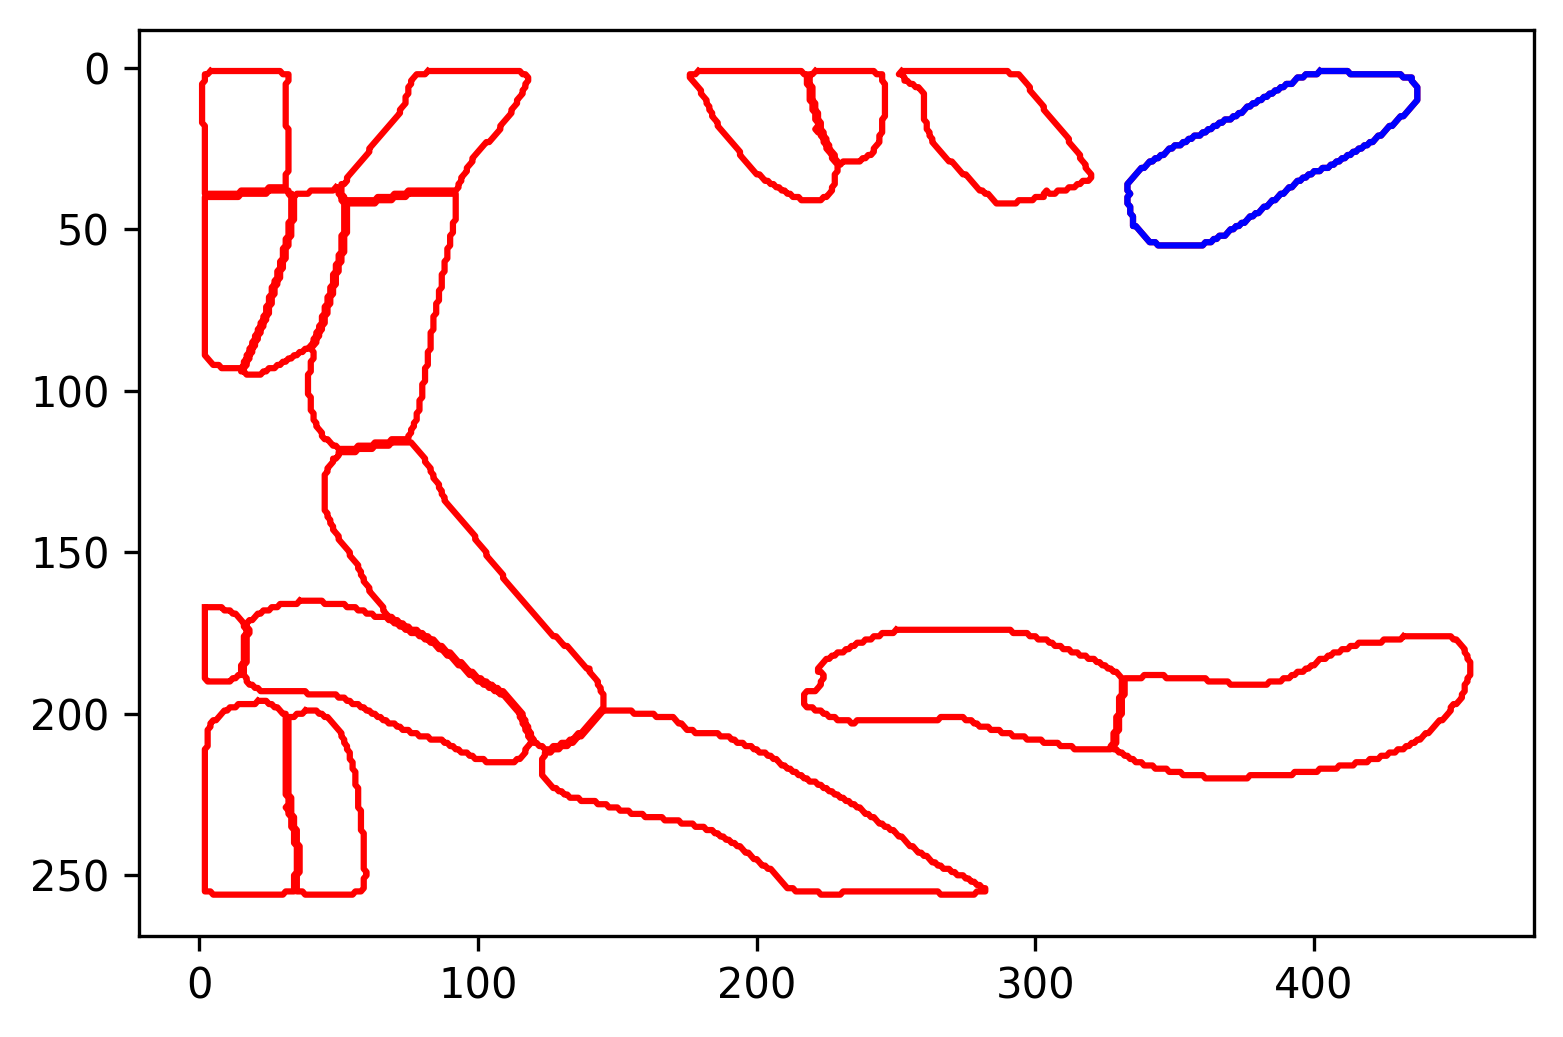

In [68]:
#plot just the outlines. I mostly use this to get a sense for each outline. 
for o in outl:
    plt.plot(o[:,0], o[:,1], color='r')
plt.plot(outl[5][:,0], outl[5][:,1], color = 'blue')
plt.gca().invert_yaxis()

# Finding the centers 

In [69]:
# define the image from the data.
img_centers = img.copy()

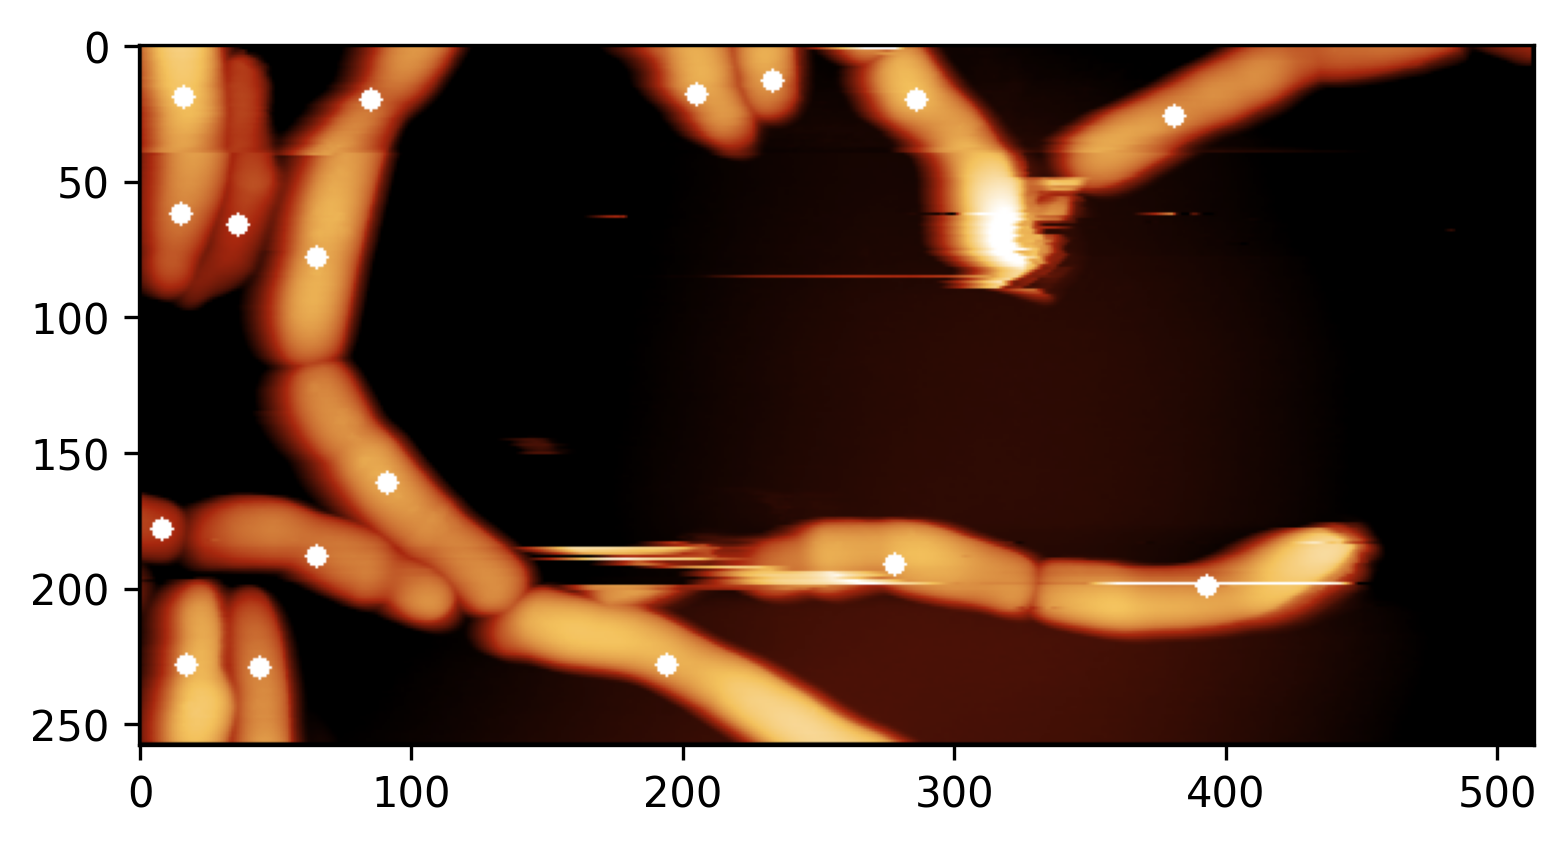

In [70]:
# loop over the contours and define each center.
centers = []
for c in outl:
    # compute the center of the contour
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centers.append([cX, cY])
    # draw the contour and center of the shape on the image
    cv2.circle(img_centers, (cX, cY), 4, (255, 255, 255), -1)
# show the image
plt.imshow(img_centers)
centers = np.array(centers)
# Alright, so these cX and cYs contain all of the information I need on the center of the images. 

## Using Utils
useful utils may include:
- fill_holes_and_remove_small_masks
- get_mask_compactness
- get_mask_stats
- distance_to_boundary. This determines the distance of each pixel in a mask to the boundaries (I think). If I find the max of this it might help me find a center, although the rod shape may screw with that. 
- metrics 
- remove_edge_masks. This removes any mask that has a pixel on the edge of the image, might be helpful when cleaning up images. Would have to be careful not to screw with the metadata. Hmm, this does not work so good

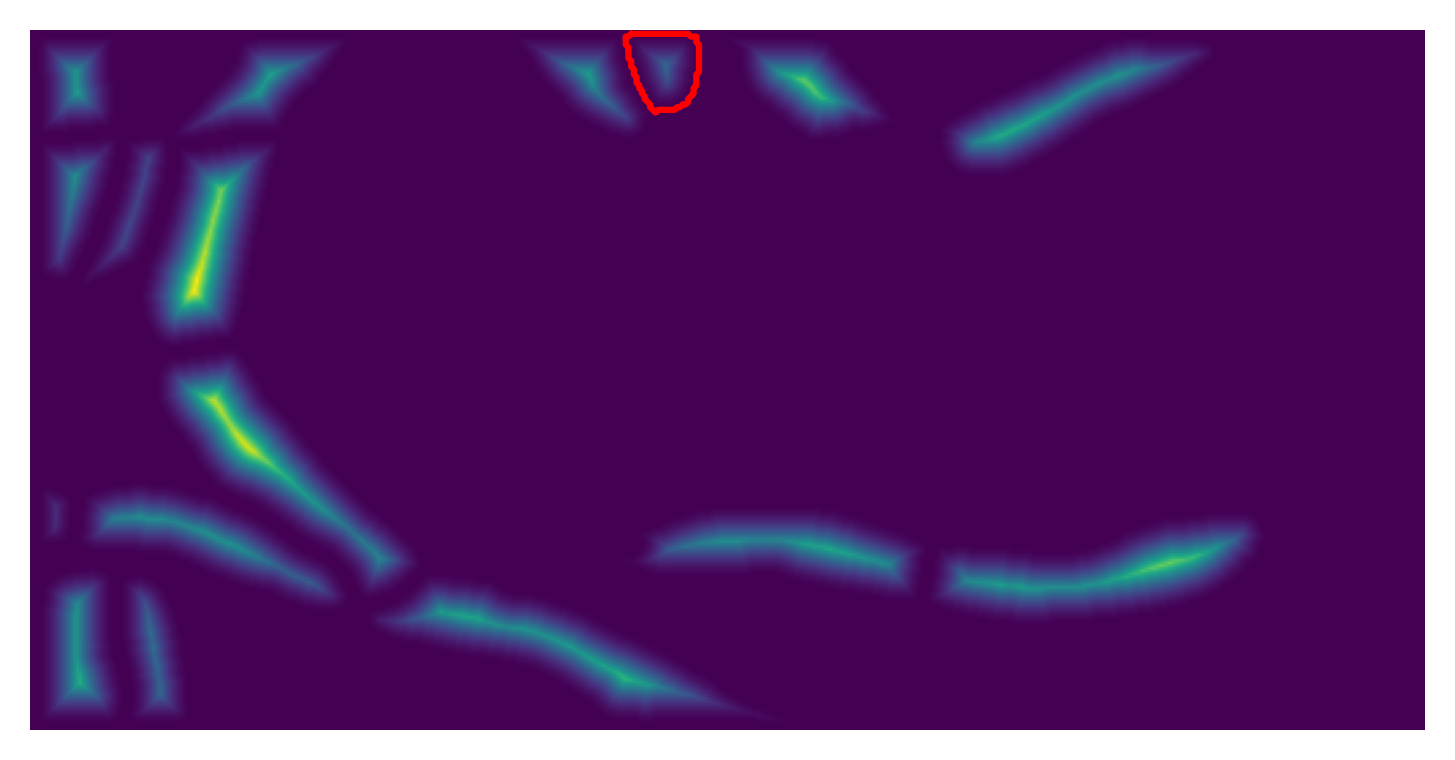

In [71]:
plt.imshow(utils.distance_to_boundary(dat['masks']))
# plot an individual cell of choice. 
plt.plot(outl[3][:,0], outl[3][:,1], color = "r")
plt.axis("off")
plt.savefig("test.png")

# Determining overlap

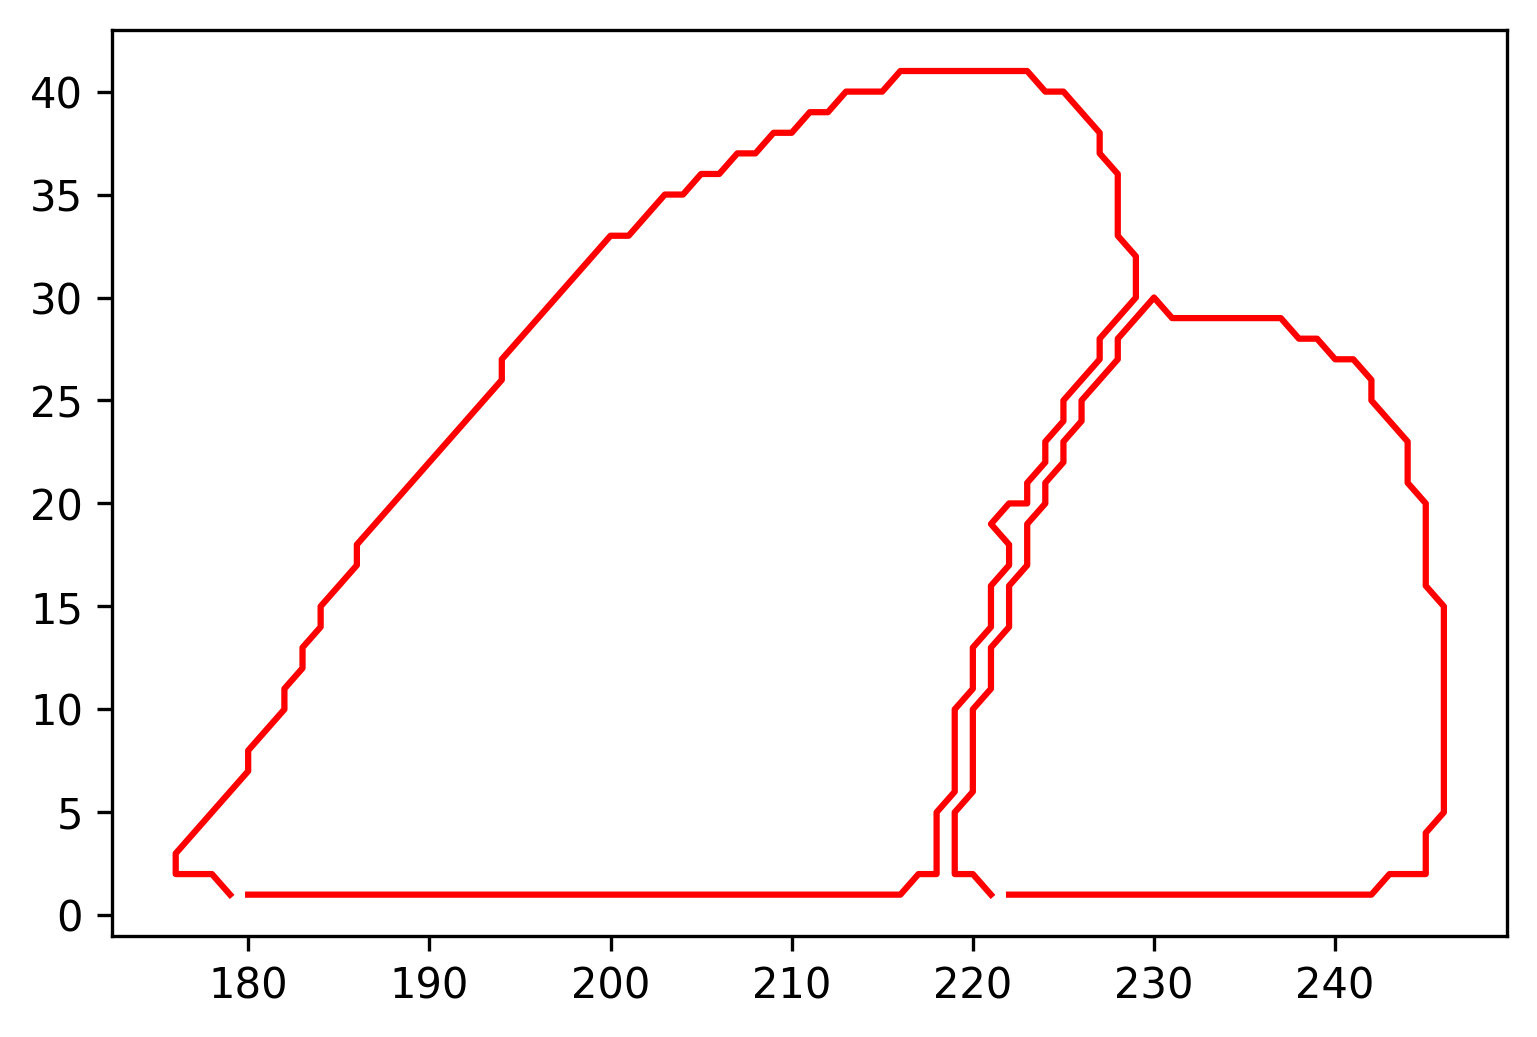

In [72]:
# plot the two cells where I want to determine touching surfaces. 
plt.plot(outl[3][:,0], outl[3][:,1], color = "r")
plt.plot(outl[2][:,0], outl[2][:,1], color = "r")
#plt.xlim((310,400))

In [23]:
# An earlier version that just draws the lines for educative purposes. 
for out_cell, cen_cell in zip(outl, centers):
    for cen_oth in centers:
        distance = dist.euclidean(cen_cell,cen_oth)
        if distance > 150 or distance == 0:
            continue
        cv2.line(img_centers, (int(cen_cell[0]),int(cen_cell[1])), (int(cen_oth[0]),int(cen_oth[1])), color = (0, 0, 255))

In [11]:
# hmmmm, this takes like, 10 seconds to run, and for an image of this size that is pretty pathetic... 
cell_overlaps = []
for out_cell, cen_cell in zip(outl, centers):
    adj = 0
    for out_oth, cen_oth in zip(outl, centers):
        cent_dist = dist.euclidean(cen_cell,cen_oth)
        if cent_dist > 150 or cent_dist == 0:
            continue
        for pixel1 in out_cell:
            for pixel2 in out_oth:
                distx = np.abs(pixel1[0]-pixel2[0])
                disty = np.abs(pixel1[1]-pixel2[1])
                if distx + disty == 1:
                    adj = adj + 1
    cell_overlaps.append(adj)

# I think the box idea in here is very good, but for now I can keep going with the slow version. 
Alright, this worked really well but it is pretty damn slow considering the task at hand. I think I can get away with a certain lack of speed at the moment. Perhaps a faster way to do this would be to draw those boxes around each of the cells and if those boxes intersect, then I will do the pixel algorithm.

Another poosibility would be to literally just enlarge the outline in every direction and detect intersection that way.

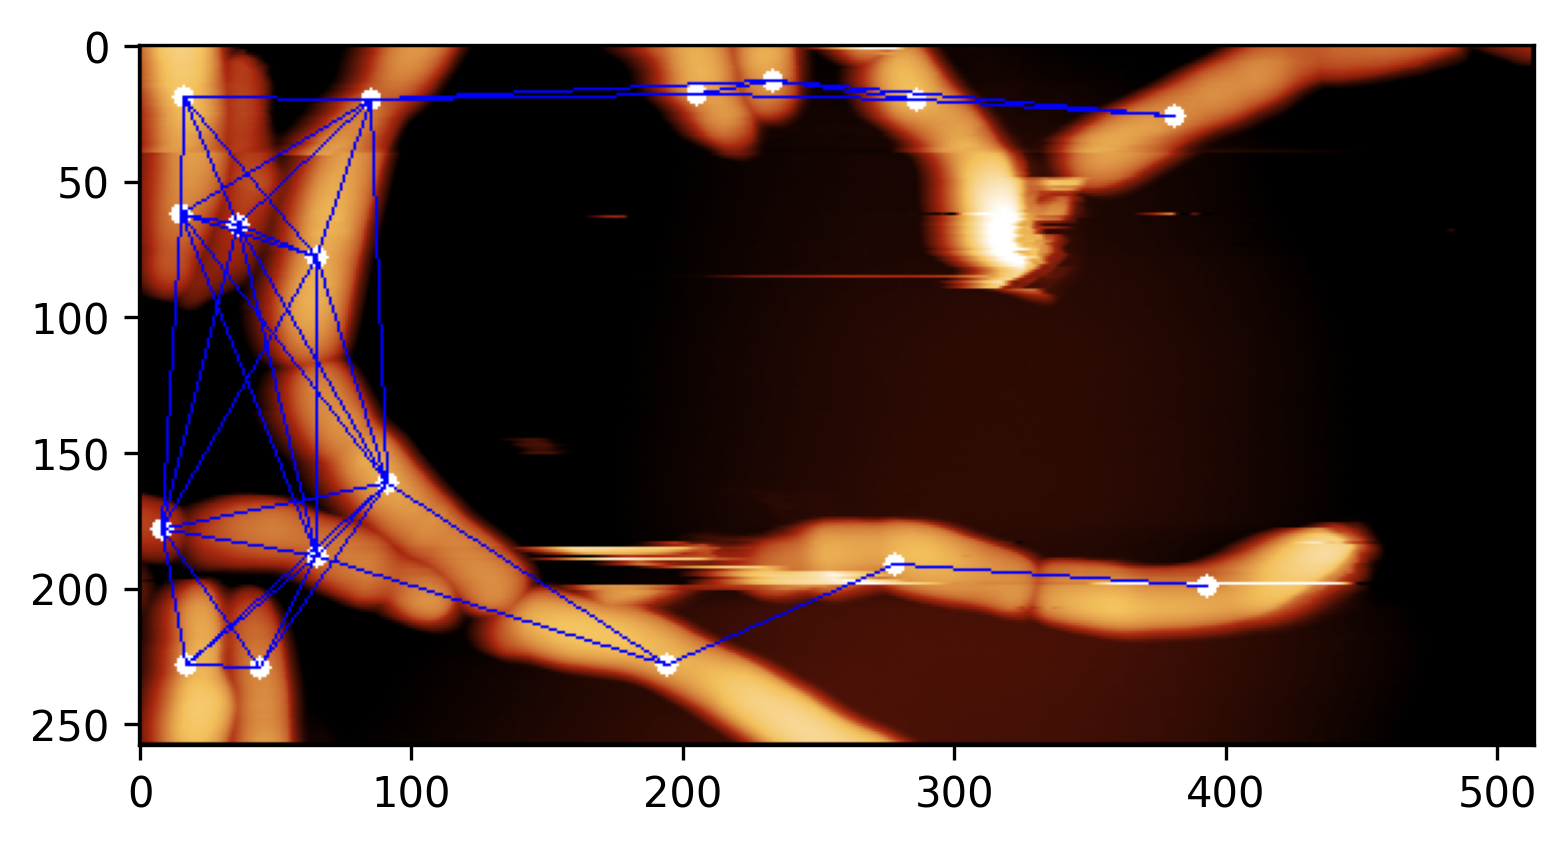

In [24]:
plt.imshow(img_centers)

### For now, I have set the cuttoff at 150 pixels distance from the centroid.

# Note too self:
If I can make a set of images that is literally just centroids that would be very helpful. 

# Putting it all together. 

I want to start creating a table where, for each cell, we have the perimeter, the area, the amount of overlap, the position of the center, 

In [21]:
# calculate some extra values. 
perimeters = utils.get_mask_perimeters(dat['masks'])
areas = []
for o in outl:
    areas.append(cv2.contourArea(o))


In [25]:
print(centers)
print(cell_overlaps)
print(perimeters)
print(areas)

[[ 16  19]
 [ 85  20]
 [205  18]
 [233  13]
 [286  20]
 [381  26]
 [ 36  66]
 [ 15  62]
 [ 65  78]
 [ 91 161]
 [ 65 188]
 [  8 178]
 [278 191]
 [393 199]
 [ 17 228]
 [ 44 229]
 [194 228]]
[32, 50, 39, 39, 0, 0, 142, 108, 131, 157, 113, 20, 27, 27, 59, 59, 35]
[134.72792206 180.02438662 158.12489168  99.11269837 184.50966799
 262.93607486 165.88225099 157.35533906 237.88225099 305.06096654
 261.13708499  69.55634919 278.36753237 311.92388155 175.11269837
 156.18376618 370.1492783 ]
[1105.5, 1545.0, 1291.5, 611.0, 1700.0, 2842.0, 1044.0, 1299.5, 2943.0, 3829.5, 2680.0, 296.5, 2971.0, 3759.5, 1736.0, 1257.5, 3890.5]


## Save individual masks as png files

In [4]:
for idx, cell in enumerate(outl[:]):
    # mask outline
    mask = np.zeros(img.shape[0:2], dtype=np.uint8)
    channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,)*channel_count
    cv2.fillPoly(mask, [cell], ignore_mask_color)
    
    # crop the cell
    x = cell.flatten()[::2]
    y = cell.flatten()[1::2]

    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = mask[topy:bottomy+1, topx:bottomx+1]
    
    #cv2.imwrite(os.path.join(name, str(idx) + ".png" ), out)
    im = Image.fromarray(out)
    im.save("Individual_masks/" + str(idx) + ".png")

In [ ]:
# Working on how I would like to save all of this metadata to file. 

def save_metadata(count_vectors, path_to_save):
    # Calculate the longest cds region in our new list of counts
    l_tr = find_max_list(count_vectors)

    # Define a header that includes labels for each value.
    header=["transcript_id","gene_id"]

    # insert that header into our counts list. 
    count_vectors.insert(0,header)
    
    # Save the newly altered list as a csv. 
    with open(path_to_save, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(count_vectors)

# Goals:
- Find center of all contours. Completed!!!
- Calculate if contours are touching each other and how much overlap there is. Completed!!! But improvements can be made to speed.
- Tell how distant the cell was from other contours in general? 
- Where was the cell in the overall image. 
- What was the time point of this image. Can calculate based on image name? 
- Use optical flow to track cell movement on a basic level. 
- Find a way to auto filter those weird looking cells. 
- What am I going to do when the pngs seem to change size randomly? Will any tracking I implement be able to cope? 
- How do I determine if cells are dividing vs being smushed together? Need the help of the actual data points? only bacteria connected pole to pole are touching? Take into account the time tracking? Maybe it should have an event for when a new cell appears? Would such an event be biased by artifacts that occasionally split one cell into two cells? 

#### Hmmm, I need to start thinking of how I really want all of this to be organized. Like, I have to seperate every cell, but does he want me to put them back together? What are we trying to do with all this data?

# Ultimate goal. 
For each cell, there is a table of metadat. The columns of this metadata table are the parameters we are interested in (overlap, length of skeleton, ridgeline, etc) The rows of the table are time points, so that at each timepoint we have every parameter of interest. This could allow us to see things like the volume change after division or the path of movement that a cell takes.